# Entropy

### Outline

In this notebook, we introduce the following topics:
- Surprisal/information content
- Entropy
- Cross-entropy loss

### Setup
The end-goal of this lecture is to develop a working understanding of cross-entropy loss, which is used train classifiers (e.g., logistic regression and... neural networks!). 

Thus, as usual we will assume that we have a labelled (train) dataset for classification with the following specifications:
- There are $m$ samples.
- There are $n$ features $X_1,\dotsc,X_n$ (discrete or continuous, doesn't matter much for this notebook), each represented by a column $\mathbf{x}_j \in \mathbb{R}^m$ in the dataset.
- A categorical target $Y$ which can take one of $k$ values, encoded for simplicity as $\mathcal{C} = \{1,\dotsc,k\}$, represented by a column $\mathbf{y} \in \mathbb{R}^m$ in the dataset.

### Motivating problem
If we have generated a vector of predicted probabilities for the classes $\mathcal{C}$, how do we then compare these probabilities to the true class labels? To answer this question, we take a step back and approach a more general problem: 

*How do we compare two probability distributions over $\mathcal{C}$?*

We will work our way up to a satisfactory answer in two steps:
1. We first explore how to encode the uncertainty of a single event (surprisal).
2. We then extend this concept to the average uncertainty of a probability distribution (entropy).
3. We discuss how to use entropy to compare two probability distributions (cross-entropy).

### 1. Surprisal
Here, I follow the fantastic exposition found in this video by Artem Kirsanov: https://www.youtube.com/watch?v=KHVR587oW8I.

#### Experiments and outcomes
It will be useful to think of $Y$ as an experiment and $\mathcal{C}$ as the set of possible outcomes of the experiment. Assume that there is a probability distribution $p:\mathcal{C} \to [0,1]$ which governs how likely we observe a particular outcome when we run the experiment $Y$. 

Recall that an *event* $A$ is a subset of $\mathcal{C}$. The probability of $A$, denoted $p(A)$, is simply the sum of the probabilities of the outcomes in $A$. When we run the experiment $Y$, we say that **$A$ occurs** if the outcome of $Y$ is in $A$. For example, if $Y$ represents rolling a die, then we say that the event $A = \{1,2,3\}$ occurs if the outcome of $Y$ is either $1$, $2$, or $3$. 

#### Desired properties of surprisal
The **surprisal** of an event $A \subset \mathcal{C}$, is a quantity which measures how surprised you would be if $A$ occured; let's denoted this by $S(A)$. Equivalently, to drive home the concept, we can think of it as how surprised you'd be if you made a guess before the experiment and then it turned out your guess was correct. 

**Example**: How surprised would you be if you correctly guessed the outcomes of the following experiments?
1. *A (fair) coin flip*: So-so, because after all, it was a 50/50 chance.
2. *A (fair) die roll*: A bit more surprised, because there are 6 outcomes, so you had only a 1-in-6 chance.
3. *Someone's birthday*: Very surprised!
4. *The outcome of a lottery draw* (with millions of possibilities): Staggeringly surprised!!

In a nutshell, what we are searching for is a *surprisal function*
\begin{equation*}
    f : (0,1) \to (0,\infty)
\end{equation*}
that transforms "probabilities" into "surprisals". We then define $S(A) = f(p(A))$ (that is, the surprisal of an event is purely a function of how probable the event is).  

The properties we definitely want in $f$ are: 
1. $f(p)$ is continuous (i.e. events with similar probability are similarly surprising).
2. $f(p) \to 0$ as $p \to 1$ (i.e. as we approach complete certainty that an event will occur, our surprisal at observing it should approach 0).

With these constraints, there are several possible candidates for $f(p)$. We plot a few of them below.

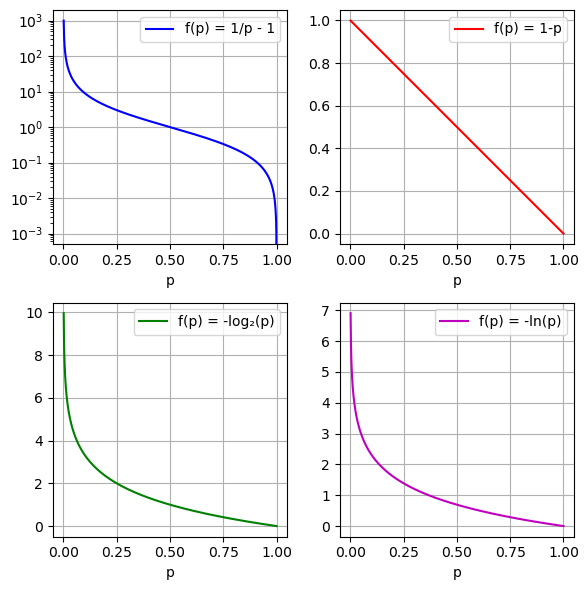

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))

# Create x values (avoiding x=0 for functions with singularities)
p = np.linspace(0.001, 1, 1000)

# Plot each function
ax1.plot(p, (1/p) - 1, 'b-', label='f(p) = 1/p - 1')
ax1.set_yscale('log')
ax1.set_xlabel('p')
ax1.grid(True)
ax1.legend()

ax2.plot(p, 1-p, 'r-', label='f(p) = 1-p')
ax2.set_xlabel('p')
ax2.grid(True)
ax2.legend()

ax3.plot(p, -np.log2(p), 'g-', label='f(p) = -log₂(p)')
ax3.set_xlabel('p')
ax3.grid(True)
ax3.legend()

ax4.plot(p, -np.log(p), 'm-', label='f(p) = -ln(p)')
ax4.set_xlabel('p')
ax4.grid(True)
ax4.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

#### Definition of surprisal
The definition of surprisal that we choose is
\begin{equation*}
    S(p) = \ln (1/p) =  -\ln (p).
\end{equation*}
More generally, we can use any base for the logarithm (it only scales $S(p)$ by a constant positive factor). 

This definition is extremely nice because, in addition to the properties we wanted, it also satisfies the following *functional equation*:
\begin{equation*}
    S(p_1 p_2) = S(p_1) + S(p_2).
\end{equation*}
This means that if $A$ and $B$ are independent events, then our surprisal at the joint event $A\cap B$ is the sum of surprisals $S(A) + S(B)$.  

In the language of variables, suppose we have two categorical variables $X$ and $Y$. Let $p(x,y)$ denote the joint probability of $X=x$ and $Y=y$. Suppose that $X$ and $Y$ are independent, i.e. $p(x,y) = p(x)p(y)$ for all possible outcomes $x$ and $y$. Then, we have
\begin{align*}
    S(x,y) & = -\ln(p(x,y)) \\
    & = -\ln (p(x)p(y)) \\
    & = -\ln(p(x)) - \ln (p(y)) \\
    & = S(x) + S(y).
\end{align*}
So, the surprisal of the joint event $(X,Y) = (x,y)$ is the sum of the surprisal of the individual events $X = x$ and $Y=y$.

**Example.**
Suppose $X_1,\dotsc,X_n$ are consecutive rolls of a fair die. These rolls are independent (because the outcome of one roll has no bearing on the outcome of the other). Then, for any sequence of outcomes $x_1,\dotsc,x_n$ (each $x_i \in \{1,\dotsc,6\}$), we have
\begin{align*}
    S(x_1,\dotsc,x_n) & = -\ln (p(x_1,\dotsc,x_n)) \\
    & = -\ln ( \prod_{i=1}^n p(x_i)) \\
    & = - \sum_{i=1}^n \ln (p(x_i)) \\
    & = - n \ln (1/6) \\
    & = n \ln (6).
\end{align*}

#### Information content
The notion of surprisal turns out to be equivalent (up to a scaling factor) to the notion of **information content** of an event, which was introduced by Claude Shannon in his seminal 1948 paper "A Mathematical Theory of Communication". 

The basic idea is that the information content of an event $A$ is the amount of information that we gain by observing that $A$ occurs. If you think about it, the desirable properties of surprisal are exactly the properties that we want from information content:
1. The more likely an event, the less information we gain by observing it, with an event that is certain giving us no information at all.
2. Two similarly probable events yield similar amounts of information.
3. If we separately observe independent events $A$ and $B$ ,then the information from the joint event $A\cap B$ is the sum of the information from the individual events $A$ and $B$: $I(A\cap B) = I(A) + I(B)$.

There is an interesting interpretation of IC when we take our base for the log to be $2$ instead of $e$. In this case, we have $I(p) = \log_2(1/p)$, and this is approximately the number of bits (binary digits) needed to encode the number $1/p$ (more precisely, the nearest integer) in binary! 

For example, suppose our probability distribution is uniform over $\mathcal{C}$, i.e. $p(c) = 1/k$ for all $c \in \mathcal{C}$. Then, the information content of any outcome $c$ is $I(1/k) = \log_2(k)$, which is the number of bits needed to encode the integer $k$ in binary. 

There is a line of thinking which asks: *How many bits do we need to encode the outcome of an experiment $Y$ with $k$ possible outcomes*, and arrives at the IC as the optimum answer. I don't actually know much about this so I'll leave it at that.

### 2. Entropy

#### Expected values
Let's pause to ask ourselves, what exactly does it mean to say that we expect to observe an outcome $c$ around $p(c)$ of the time? Well, one perspective (the *frequentist perspective*) is to interpret this as saying that if we were to observe the outcome of $Y$ many times, then we would expect to see $c$ around $p(c)$ of the time (taken as a fraction of our total observations). For example, if we flip a fair coin $n$ times, then the proportion of heads we observe should be around $1/2$ (i.e. $p(H) = 1/2$), and similarly for tails. 

Suppose now that we have a function $f:\mathcal{C} \to \mathbb{R}$, which assigns a real number to each outcome of the experiment $Y$. For example, since we've encoded $\mathcal{C}$ as $1,\dotsc,k$, we can take $f(c) = c$ to recover the original variable $Y$, or we can take (e.g.) $f(c) = S(c)$. 

We define the **expected value** of $f$ to be
\begin{equation*}
    \mathbb{E}[f] = \sum_{c \in \mathcal{C}} p(c) f(c).
\end{equation*}
This is the weighted average of the values of $f$ over all possible outcomes, where the weights are the respective probabilities of the outcomes. Thus, more likely outcomes have a larger impact on the expected value than less likely outcomes. Thus, the $\mathbb{E}[f]$ tells us the value of $f$ that we should expect on average given the probability distribution $p$.

**Example.**
If all outcomes are equally likely (i.e. we have a uniform probability distribution), then for any function $f:\mathcal{C} \to \mathbb{R}$, we have
\begin{align*}
    \mathbb{E}[f] & = \sum_{c \in \mathcal{C}} p(c) f(c) \\
    & = \frac{1}{k} \sum_{c=1}^k f(c),
\end{align*}
which is simply the usual average of the values of $f$ over all possible outcomes. Thus, if $Y$ represents a fair die roll and $f(c) = c$, then $\mathbb{E}[f] = 3.5$.

#### Entropy as an expected value

Now, the **entropy** of a probability distribution $p:\mathcal{C} \to [0,1]$, denoted $H(p)$, is defined as  the expected value of the information content $I$ of the outcomes:
\begin{align*}
    H(p) &= \mathbb{E}[I] \\
    & = \sum_{c \in \mathcal{C}} p(c) I(c) \\
    & = -\sum_{c \in \mathcal{C}} p(c) \ln (p(c)). \\
\end{align*}
So, if we were to guess the outcome of $Y$ many times, then on average we would expect to experience $H(p)$ units of surprisal.

NOTE: The entropy is a function of the entire probability distribution. The notation $H(p)$ above is used because we are using $p$ to denote the distribution. We can also think of such a distribution as a vector of probabilities $\vec{p} \in \Delta_k$. From this perspective, we see that entropy actually is a function
\begin{equation*}
    H : \Delta_k \to \mathbb{R},
\end{equation*}
which assigns to each probability distribution $\vec{p} \in \Delta_k$ a (non-negative) real number. 

#### Entropy in small cases

**Example $(k=2)$.**
Suppose we are in the binary case, i.e. $\mathcal{C} = \{0,1\}$. For simplicity, let's write $p(1) = p$ and $p(0) = 1-p$. (We call this the **Bernoulli Distribution** with parameter $p$.) Then, we have
\begin{align*}
    H(p) &= -p \ln (p) - (1-p) \ln (1-p)\\
    & = p\ln \left(\frac{1}{p}\right) + (1-p) \ln \left(\frac{1}{1-p}\right).
\end{align*}
You will prove in HW 3 that this is maximized at $p=1/2$; in other words, the Bernoulli distribution with parameter $p=1/2$ has the highest entropy of all possible Bernoulli distributions. This quite intuitive: the average uncertainty for two outcomes is highest when the outcomes are equally likely (i.e. they are indistinguishable).

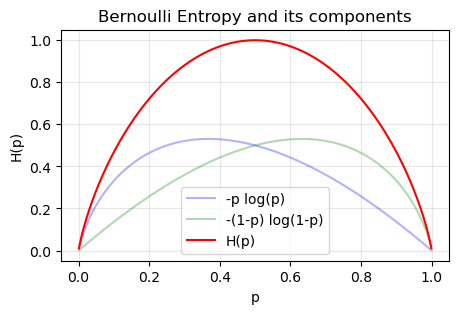

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create data points
p = np.linspace(0.001, 0.999, 1000)  # Avoid 0 and 1 due to log(0)

# Calculate the components
term1 = -p * np.log2(p)
term2 = -(1-p) * np.log2(1-p)
entropy = term1 + term2

# Create the plot
plt.figure(figsize=(5,3))

# Plot components with transparency
plt.plot(p, term1, color='blue', alpha=0.3, label='-p log(p)')
plt.plot(p, term2, color='green', alpha=0.3, label='-(1-p) log(1-p)')

# Plot total entropy
plt.plot(p, entropy, color='red', label='H(p)')
plt.grid(True, alpha=0.3)
plt.xlabel('p')
plt.ylabel('H(p)')
plt.title('Bernoulli Entropy and its components')
plt.legend()
plt.show()

**Important remark.** As the above picture shows, $H(p)$ goes to $0$ as $p \to 0$ or $p \to 1$. This is because both of the terms in the sum go to $0$ as $p \to 0$ or $p \to 1$. To make sense of this, we need to define  the term $0 \ln (0)$ to be $0$!

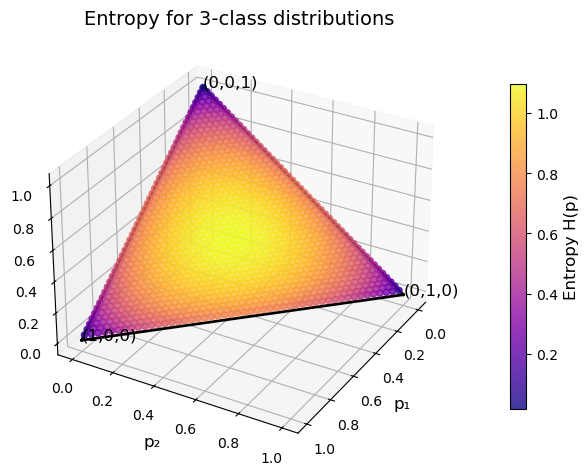

In [4]:
# Create figure
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

# Generate simplex points
n = 50  # resolution
p1_vals = np.linspace(0.001, 0.999, n)
p2_vals = np.linspace(0.001, 0.999, n)

p1_grid, p2_grid = np.meshgrid(p1_vals, p2_vals)
mask = (p1_grid + p2_grid <= 0.999)

p1 = p1_grid[mask]
p2 = p2_grid[mask]
p3 = 1 - p1 - p2

# Calculate entropy
def safe_log(x):
    return np.log(x + 1e-10)  # avoid log(0)

entropy = -p1 * safe_log(p1) - p2 * safe_log(p2) - p3 * safe_log(p3)

# Create scatter plot
sc = ax.scatter(p1, p2, p3, c=entropy, cmap='plasma', s=20, alpha=0.8)

# Plot simplex edges
vertices = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
edges = [[0, 1], [1, 2], [2, 0]]

for edge in edges:
    ax.plot3D([vertices[edge[0]][0], vertices[edge[1]][0]],
                [vertices[edge[0]][1], vertices[edge[1]][1]],
                [vertices[edge[0]][2], vertices[edge[1]][2]], 'k-', lw=2)

# Label vertices
ax.text(1, 0, 0, "(1,0,0)", fontsize=12)
ax.text(0, 1, 0, "(0,1,0)", fontsize=12)
ax.text(0, 0, 1, "(0,0,1)", fontsize=12)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.7, pad=0.1)
cbar.set_label('Entropy H(p)', fontsize=12)

# Set view angle
ax.view_init(elev=30, azim=30)

# Set labels and title
ax.set_xlabel('p₁', fontsize=12)
ax.set_ylabel('p₂', fontsize=12)
ax.set_zlabel('p₃', fontsize=12)
ax.set_title('Entropy for 3-class distributions', fontsize=14)

plt.tight_layout()
plt.show()

**Example $(k=3)$.**
Suppose $\mathcal{C} = \{1,2,3\}$. Calling the respective probabilities $p_1,p_2,$ and $p_3$, we have
\begin{align*}
    H(p) &= -p_1 \ln (p_1) - p_2 \ln (p_2) - p_3 \ln (p_3)\\
    & = p_1\ln \left(\frac{1}{p_1}\right) + p_2 \ln \left(\frac{1}{p_2}\right) + p_3 \ln \left(\frac{1}{p_3}\right).
\end{align*}
Note the $(p_1,p_2,p_3)$ lies on the triangle $\Delta_3 \subset \mathbb{R}^3$. In the plot above, we've visualized $H(p)$ using color. Note that the smallest value of $H(p)$ is $0$, which occurs when one of the probabilities is $1$ and the others are $0$. The largest value of $H(p)$ is $\ln(3)$, which occurs when all three probabilities are equal to $1/3$ (i.e. the distribution is uniform).

**Remark.** 
The examples for $k=2$ and $k=3$ illustrate an important point about the possible values of $H(p)$ for all possible distributions with a fixed $k$. Namely, $H(p)$ is largest when the distribution is uniform, and smallest when the distribution is deterministic. Thus, when there are $k$ classes, we have the bounds
\begin{equation*}
    0 \leqslant H(p) \leqslant \ln (k).
\end{equation*}

#### Example: Entropy of English text

The "entropy of the English language" is a concept from information theory that attempts to quantify the average amount of information contained in a string of text written in English. It's essentially a measure of the language's intrinsic unpredictability or randomness.

If the English language had very low entropy, it would be highly predictable, and we could easily guess the next letter or word. Conversely, high entropy implies more surprise and less predictability. NOTE: The entropy of English is not a fixed value. It depends on the model used to estimate it and the specific corpus of text being analyzed. Estimates typically range from 1 to 1.5 bits per character, but these are just approximations.

### 3. Cross-entropy

Suppose we have  a "true" probability distribution $p:\mathcal{C} \to [0,1]$ and a "predicted" probability distribution $q:\mathcal{C} \to [0,1]$. For simplicity, assume that $\mathcal{C} = \{1,\dotsc,k\}$, and put $p_i = p(i)$ (true probability of $i$) and $q_i = q(i)$ (predicted probability of $i$). 

According to our predicted distribution, the surprisal for each $i$ is $-\ln(q_i)$. Using this as our predicted surprisal, if we measure many many outcomes, then since each outcome actually happens $p_i$ of the time (and not $q_i$ of the time), we would experience an average surprisal of 
\begin{equation*}
    H(p,q) =  -\sum_{c \in \mathcal{C}} p_i \ln (q_i).
\end{equation*}
This is called the **cross-entropy** of $p$ and $q$. It measures the expected value of the *surprisal*, given that our predictions follow the distribution $q$ whereas the true distribution is $p$.

NOTE: The cross-entropy is not symmetric in $p$ and $q$. That is, $H(p,q) \neq H(q,p)$ in general. This is because the cross-entropy is not a distance function, but rather a measure of how well $q$ approximates $p$.

**Example $(k=2)$.**
Let's again consider the binary case (popularly referred to as "binary cross-entropy"). Denoting the true probabilities by $p$ and $(1-p)$, and the predicted probabilities as $q$ and $(1-q)$, we have
\begin{equation*}
    H(p,q) = -p \ln (q) - (1-p) \ln (1-q).
\end{equation*}
This is a function of two real numbers $p$ and $q$, both lying in the interval $[0,1]$. So, we can visualize all possible values of $H(p,q)$ as the graph of a function $H:\mathbb{R}^2 \to \mathbb{R}$, where the domain is the square $[0,1]^2$.

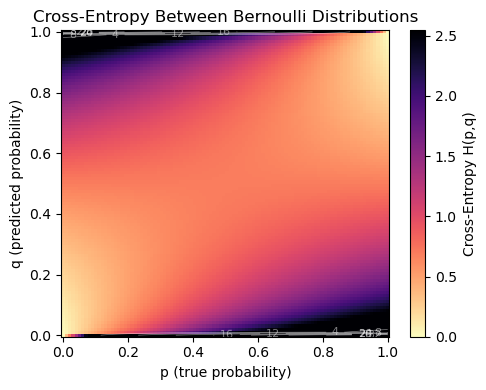

In [5]:
def binary_cross_entropy(p, q):
    """
    Calculate cross-entropy between Bernoulli distributions with parameters p and q
    H(p,q) = -p*log(q) - (1-p)*log(1-q)
    """
    # Handle edge cases to avoid log(0)
    q = np.clip(q, 1e-15, 1-1e-15)
    return -p * np.log(q) - (1-p) * np.log(1-q)

# Create a grid of points
n = 100
p_values = np.linspace(0, 1, n)
q_values = np.linspace(0, 1, n)
P, Q = np.meshgrid(p_values, q_values)

# Calculate cross-entropy for each point
Z = binary_cross_entropy(P, Q)

# Create the plot
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

# Create a custom normalization that emphasizes darker colors
vmax = np.percentile(Z, 95)  # Use 95th percentile as maximum value
im = ax.pcolormesh(P, Q, Z, cmap='magma_r', shading='auto', vmax=vmax)

# Add colorbar and labels
cbar = plt.colorbar(im)
cbar.set_label('Cross-Entropy H(p,q)')
plt.xlabel('p (true probability)')
plt.ylabel('q (predicted probability)')
plt.title('Cross-Entropy Between Bernoulli Distributions')

# Add contour lines for better visualization
contour = plt.contour(P, Q, Z, levels=10, colors='white', alpha=0.5, linewidths=0.5)
plt.clabel(contour, inline=True, fontsize=8)

plt.tight_layout()
plt.show()

In [6]:
import ipywidgets as widgets
from IPython.display import display

def plot_binary_cross_entropy(p_value=0.3):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Binary Cross-Entropy Visualization', fontsize=16)
    
    q_range = np.linspace(0.001, 0.999, 1000)
    
    bce_vs_q = binary_cross_entropy(p_value, q_range)
    
    ax.plot(q_range, bce_vs_q, 'b-', lw=2)
    
    # Add vertical dashed line at q = p
    ax.axvline(x=p_value, color='black', linestyle='--', lw=1.5)
    
    ax.set_xlabel('q (Predicted Probability)')
    ax.set_ylabel('Binary Cross-Entropy H(p,q)')
    ax.set_title(f'H(p,q) vs q with p={p_value:.2f}')
    ax.grid(True)
    ax.set_ylim(0, min(10, np.max(bce_vs_q) * 1.1))
    
    # Set fixed axis limits
    ax.set_xlim(0.001, 0.999)
    ax.set_autoscale_on(False)
    
    plt.tight_layout()
    plt.show()

# Create interactive widget for p only
p_slider = widgets.FloatSlider(
    value=0.3, min=0.01, max=0.99, step=0.01,
    description='p value:',
    continuous_update=False
)

# Display interactive plot (removed q_value parameter)
interactive_plot = widgets.interactive(plot_binary_cross_entropy, 
                                      p_value=p_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='p value:', max=0.99, min=0.…

## Cross-entropy loss

#### Fundamental property of cross-entropy

The cross-entropy is a measure of how well the predicted distribution $q$ approximates the true distribution $p$. The fundamental property of cross-entropy is that $$H(p,q) \geqslant H(p)$$ and $$H(p,q) = H(p) \textup{ if and only if } p=q.$$ 

This means that the cross-entropy is minimized when the predicted distribution is equal to the true distribution. The more our predicted distribution deviates from the true distribution, the greater will be the cross-entropy between the two. It is this property that makes cross-entropy a suitable loss function for training classifiers!

You can see this property in the above plot: as we change the true Bernoulli distribution $\vec{p} = (p,1-p)$, the cross-entropy $H(\vec{p},\vec{q})$ is minimized when the predicted distribution $\vec{q} = (q,1-q)$ is equal to the true distribution. 

#### Cross-entropy as a dot product
It might be useful to think of the cross-entropy as a dot product. Let $\vec{p} = (p_1,\dotsc,p_k)$ and $\vec{q} = (q_1,\dotsc,q_k)$ be the true and predicted probability distributions, respectively. Then, we have
\begin{equation*}
    H(\vec{p},\vec{q}) = -\vec{p} \cdot \ln(\vec{q}),
\end{equation*}
where $\ln(\vec{q}) = (\ln(q_1),\dotsc,\ln(q_k))$ is the elementwise logarithm of $\vec{q}$.

#### True probabilities of a sample
Let's get back now to our dataset. We need to carefully consider what is meant by the "true" probability vector $\vec{p}(\vec{x}) \in \Delta_k$ for a given sample (i.e. the probability distribution over the classes given the features of the sample).

The basic idea is to encode the deterministic distributions at **one-hot vectors**. This means that we associate the classes $\mathcal{C} = \{1,\dotsc,k\}$ with the standard basis vectors $e_1,\dotsc,e_k \in \mathbb{R}^k$:
\begin{equation*}
\begin{alignedat}{1}
    &\textup{If $\vec{x}$ is in class $1$ then $\vec{p}(\vec{x}) = e_1 = (1,0,\dotsc,0,0)$.} \\
    &\textup{If $\vec{x}$ is in class $2$ then $\vec{p}(\vec{x}) = e_2 = (0,1,0,\dotsc,0)$.} \\
    &\vdots \\
    &\textup{If $\vec{x}$ is in class $k$ then $\vec{p}(\vec{x}) = e_k = (0,0,\dotsc,0,1)$.}
\end{alignedat}
\end{equation*}
In other words, the true probability of each sample is the vertex in $\Delta_k$ corresponding to the class of the sample.

#### Cross-entropy loss for a sample
Suppose now that we have a soft classifier 
\begin{equation*}
    F : \mathbb{R}^n \to \Delta_k,
\end{equation*}
which assigns to each sample $\vec{x} \in \mathbb{R}^n$ a vector of predicted probabilities $\vec{q}(\vec{x})$. Let $\vec{p}(\vec{x})$ denote the true probability vector for the sample. Then, the cross-entropy for the sample $\vec{x}$ is given by
\begin{align*}
    H(\vec{p}(\vec{x}),\vec{q}(\vec{x})) & = -\vec{p}(\vec{x}) \cdot \ln(\vec{q}(\vec{x}))\\
    & = -\sum_{i=1}^k p_i(\vec{x}) \ln(q_i(\vec{x})).
\end{align*}
This is the dot product of the true probability vector and the logarithm of the predicted probability vector for that sample.

**Example.**
Suppose we have a binary classifier $F : \mathbb{R}^n \to \Delta_2$. For a given sample $\vec{x}$, the true probability vectors are
\begin{equation*}
    \vec{p}(\vec{x}) =
    \begin{cases}
        (1,0) & \textup{if $\vec{x}$ is in class $1$}, \\
        (0,1) & \textup{if $\vec{x}$ is in class $2$}.
    \end{cases}
\end{equation*}
Suppose our predicted probabilities for the sample are $\vec{q}(\vec{x}) = (q,1-q),$ that is: 
\begin{align*}
    q & \textup{ is the predicted probability that $\vec{x}$ is in class $1$.}\\
    1-q & \textup{ is the predicted probability that $\vec{x}$ is in class $2$.}
\end{align*}

Then, the cross-entropy loss for the sample $\vec{x}$ is
\begin{align*}
    H(\vec{p}(\vec{x}),\vec{q}(\vec{x})) & = -\vec{p}(\vec{x}) \cdot \ln(\vec{q}(\vec{x})) \\
    & = 
    \begin{cases}
        - \ln q & \textup{if $\vec{x}$ is in class $1$}, \\
        - \ln (1-q) & \textup{if $\vec{x}$ is in class $2$}.
    \end{cases}
\end{align*}
NOTE: When we take a dot product with a one-hot vector, we simply pick out the class $i$ of the sample, and take the corresponding $-\ln(q_i)$ term from the predicted probability vector. Thus, the cross-entropy loss for a sample is simply the negative logarithm of the predicted probability of the true class of the sample.

### Cross-entropy loss for a dataset
Finally, the cross-entropy loss for a dataset is simply the average cross-entropy loss over all samples in the dataset. If we have a dataset of $m$ samples, then the cross-entropy loss is given by
\begin{align*}
    L & = \frac{1}{m} \sum_{i=1}^m H(\vec{p}(\vec{x}_i),\vec{q}(\vec{x}_i))\\
    & = \frac{1}{m} \sum_{i=1}^m -\vec{p}(\vec{x}_i) \cdot \ln(\vec{q}(\vec{x}_i))\\
    & = -\frac{1}{m} \sum_{i=1}^m \underbrace{ \left(  \sum_{j=1}^k p_j(\vec{x}_i) \ln(q_j(\vec{x}_i)) \right) }_{\textup{CE for $i$-th sample}}.
\end{align*}